# Introduction

We try to investigate in depth the lyrics of one of the most famous and influential singer in Egypt, namely, شادية. We use statistical, visual, data mining, and exploratory data analysis tools in order to shed light into the artist's career.

Musical lyrics may represent an artist's perspective, as well as the corresponding composer's and lyricist's perspectives. Lyric analysis is no easy task. Because **it is often structured so differently than prose**, it requires caution with assumptions and careful choice of analytic techniques.

Musical lyrics permeate our lives and influence our thoughts, feelings, and perspectives in very subtle ways. The concept of **Predictive Lyrics** is beginning to take its position in research papers and graduate theses. This case study will just touch on a few pieces of this emerging subject.

Fatma Ahmed Kamal Shaker (فاطمة أحمد كمال شاكر), commonly known as Shadia (شادية) is one of the most popular and influential artists in Egypt and the Arab region. She is considered to be one of the greatest Egyptian singers along with Umm Kulthum (ام كلثوم), Mohamed Abdel Wahab (محمد عبد الوهاب), Mohamed Fawzi (محمد فوزي), and Abd ElHalim Hafez (عبد الحليم حافظ). Shadia was born in 1931 and died in 2017. 
Six of her movies are listed in the top 100 Egyptian movies of the 20th century. In April 2015, she became the first actress to be awarded an honorary doctorate by the Egyptian Academy of Arts (citation: @shadiawiki).

The work of Shadia is very diverse including wide range of genres from romanticism, nationalism, spiritual religion, etc. In order to celebrate this inspiring and diverse body of work, we will explore the sometimes obvious, but often hidden, messages in her lyrics. Lyric analysis is slowly finding its way into the data science and machine learning communities as the possibility of predicting "Hit Songs" approaches reality.



# Data Collection

1)  The names of all songs are collected using Wikipedia page
    [https://arz.wikipedia.org/wiki/ليستة_اغانى_شادية](https://arz.wikipedia.org/wiki/ليستة_اغانى_شاديه)

2)  The lyrics of the corresponding songs were collected using several web sites including:
-   <https://fnanen.net/klmat/alaghany/sh/shadyt.html> which contains comprehensive sets of lyrics for Arabic artists.
-   <https://ankawa.com/forum/index.php> which also contains the lyrics of many Arabic songs.

3)  Then, we have listened to all the songs on YouTube to rewrite its lyrics because in the past, they used to write only the words as they are repeated only once neglecting the many repeating as the songs are too long to write.

# Installing required libraries.

In [ ]:
!pip uninstall rpy2 -y
!pip install rpy2==3.4.2

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages(c("tidytext", "gridExtra", "wordcloud2", "plotly", "reshape2", "kableExtra", "formattable", "fGarch", "fitdistrplus"))

# Including required libraries.

In [ ]:
%%R
library(tidytext)
library(dplyr)
library(stringi)
library(tidyr)
library(ggplot2)
library(gridExtra)
library(wordcloud2)
library(readr)
library(scales)
library(plotly)
library(data.table)
library(utf8)
library(RColorBrewer)
library(reshape2) 
library(knitr) # for dynamic reporting
library(kableExtra) # create a nicely formatted HTML table
library(formattable) # for the color_tile function
#library(modeest) # to estimate the mode of a distribution of samples
library(purrr)
#library(ggwordcloud)
library(fGarch)
library(fitdistrplus)

# Reading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Reading the csv file containing Shadia songs information in the form of comma separated (csv) file. Read the stop words as well


In [ ]:
%%R
songs <- read.csv("/content/drive/MyDrive/Shadia/data/songs.csv", header = TRUE, sep = ",", 
                  stringsAsFactors = FALSE, encoding = "UTF-8", na.strings = "") # Empty fields are replace by NA.

no_of_songs <- nrow(songs)
no_of_attributes <- ncol(songs)
attrs <- names(songs)

my_stopwords <- read.table("/content/drive/MyDrive/Shadia/data/stopwords.txt", header = TRUE)
colnames(my_stopwords) <- c("Word")
no_stopwords <- nrow(my_stopwords)

# Preprocessing the data

In the following, we do some preprocessing of the data that involves the following: - removing punctuation symbols, - removing newline characters, - removing diacritics from Arabic unicode text.

All of the above are done using the arabicStemR package.

In addition, we preprocessed all the Arabic text in names, title, lyrics, etc. in order to unify the way some letters are written in order to facilitate the text mining processing coming afterwards. 

We do that in such a way to remove ambiguities in writing some particular Arabic characters in particular word positions. 
For example, the name "أحمد" can sometimes be written "احمد". 
So we unified all to be written in the same way for the alph letter. 
These include the following: 
- Replacing the letter "ي" at the end of a word by "ى". 
- Replacing the letter "أ" at the beginning or middle of a word by the letter "ا". 
- Replacing the letter "إ" at the beginning of a word by "ا". 
- Replacing "ة" at the end of a word by "ه".

Note that in all of these we relaxed the correctness of proper Arabic writing for the sake of much easier text processing and removing ambiguities, and consistency of inferring. 
For example, the composer Mohamed ElMogy is sometimes written as "محمد الموجي" and sometimes "محمد الموجى". So, we found it much easier to have one writing using the latter, even though, proper formal Arabic implies the former.

Removing newline characters, punctuation symbols, and diacritics.

In [ ]:
%%R
#invisible(sapply(1:no_of_songs, FUN = function(i)
#  invisible(sapply(1:no_of_attributes, FUN = function(j)
#    {
#     songs[i,j] <<- removePunctuation(songs[i,j])
      #songs[i,j] <<- removeNumbers(songs[i,j])
      #songs[i,j] <<- removeArabicNumbers(songs[i,j])
#     songs[i,j] <<- removeNewlineChars(songs[i,j])
#     songs[i,j] <<- removeDiacritics(songs[i,j])
#    }))))


#invisible(sapply(1:no_stopwords, FUN = function(i)
#  {
#   my_stopwords$Word[i] <<- removePunctuation(my_stopwords$Word[i])
#   my_stopwords$Word[i] <<- removeNewlineChars(my_stopwords$Word[i])
#   my_stopwords$Word[i] <<- removeDiacritics(my_stopwords$Word[i])
#  }))

Create a decade column: We add a new derived column to the original data which is "Decade". 
We aggregate each 10 years into a decade, and further partition it into two halves: the early period of the decade, namely the first 5 years, and the latter part of the decade, namely, the last 5 years.

In [ ]:
%%R
songs <- songs %>% 
  arrange(Year) %>%
  mutate(Decade = 
           ifelse(Year %in% 1945:1949, "Late 1940s",
           ifelse(Year %in% 1950:1954, "Early 1950s",
           ifelse(Year %in% 1955:1959, "Late 1950s",
           ifelse(Year %in% 1960:1964, "Early 1960s",
           ifelse(Year %in% 1965:1969, "Late 1960s",
           ifelse(Year %in% 1970:1974, "Early 1970s",
           ifelse(Year %in% 1975:1979, "Late 1970s",
           ifelse(Year %in% 1980:1984, "Early 1980s",
           ifelse(Year %in% 1985:1989, "Late 1980s",NA))))))))))

Create two new columns that divide all names (composers and lyricists) into first names and last names. 
This is done to ease the preprocessing of the Arabic text later.

In [ ]:
%%R
concat <- function(x) ifelse(length(x[-1]) != 0, stri_paste_list(list(x[-1]), sep = " "), NA)

songs <- songs %>%
  mutate(Composer_first_name= ifelse(!is.na(Composer),
                                     sapply(stri_split(Composer, tokens_only = TRUE, regex = " "), "[", 1), NA)) %>%
  mutate(Composer_last_name = ifelse(!is.na(Composer),
                                     sapply(stri_split(Composer, tokens_only = TRUE, regex = " "), FUN = "concat"), NA)) %>%
  mutate(Lyricist_first_name = ifelse(!is.na(Lyricist),
                                      sapply(stri_split(Lyricist, tokens_only = TRUE, regex = " "), "[", 1), NA)) %>%
  mutate(Lyricist_last_name = ifelse(!is.na(Lyricist),
                                     sapply(stri_split(Lyricist, tokens_only = TRUE, regex = " "), FUN = "concat"), NA))

In the following, we define a function that would try to remove ambiguities in writing some particular Arabic characters in particular word positions.

In [ ]:
%%R
sub_arabic_chars <- function(x)
{
  # We use the unicodes of the characters.
  
  # Replace "ي" with "ى".
  org <- as_utf8("*\u064A$")    # حرف ي at the end of word
  substit <- as_utf8("\u0649")    # حرف ى
  x <- sub(org, substit, x)
  
  # Replace "أ" with "ا".
  org <- as_utf8("\u0623")   # حرف أ
  substit <- as_utf8("\u0627")   # حرف ا
  x <- sub(org, substit, x)

  #### Replace "إ" with "ا".
  org <- as_utf8("\u0625")   # حرف  إ
  substit <- as_utf8("\u0627")    # حرف ا
  x <- sub(org, substit, x)
 
  # Replace "ة" with "ه".
  org <- as_utf8("\u0629")  # حرف ة
  substit <- as_utf8("\u0647")   # حرف ه
  x <- sub(org, substit, x)

  x
}

Process all Arabic words in the dataset (currently only the composers and lyricists names) so that common ambiguities in the different ways people write Arabic characters are mitigated.

In [ ]:
%%R
#handle_last_name_yae <- function(x)
#  stri_paste_list(list(sapply(unlist(stri_split(x, tokens_only = TRUE, regex = " ")),
#                              FUN = "sub_arabic_chars")), sep = " ")

#songs$Composer_first_name <- 
#  sapply(songs$Composer_first_name, FUN = "sub_arabic_chars")
#songs$Composer_last_name <- 
#  sapply(songs$Composer_last_name, FUN = "handle_last_name_yae")

#songs$Lyricist_first_name <- 
#  sapply(songs$Lyricist_first_name, FUN = "sub_arabic_chars")
#songs$Lyricist_last_name <- 
#  sapply(songs$Lyricist_last_name, FUN = "handle_last_name_yae")

# Tokenization

Generally, there are different methods and data formats that can be used to **mine** text. 
Here we use "Tidy Text": a table with one token per row. A token in our context will be a word (or an 1-gram).
**Tokenization** is therefore the process of splitting the lyrics into tokens. Here we use the R package tidytext's unnest_tokens() to do this.

Processing and mining of natural language text aims at finding the significant words in the given documents. Our first guess might be that the words appearing most frequently in a document are the most significant. 
However, that intuition is exactly opposite of the truth (you may think of it in terms of information-theoretic principles, that less frequent events carry more information when they occur). 
The most frequent words include words such as "the" or "and" which help build ideas but do not carry any significance themselves [citation: @rajaraman_mining_2012].

Such words are called **stop words** and have to be filtered out before processing and/or mining the text. 
So given any language, stop words usually refers to the most common words in a language, however, there is no single universal list of stop words that can be agreed upon by all researchers and practitioners. 
In our context, we remove stop words from the songs lyrics using the "removeStopWords" function in the R package "arabicStemR". 
This package contains an Arabic stop word list containing 258 words and include words such as (لا/no), (لأنه/because), (لو/if).
This list of stop words has two constraints: (1) its size is limited and (2) it is done for modern standard Arabic, hence, it lacks a lot of words in the Egyptian dialect. However, as we will see below in the analysis and results, the error or noise resulting from these two constraints are minimal and does not affect the quality of the results.

Extract tokens

In [ ]:
%%R
songs <- songs %>%
  unnest_tokens(Word, Lyrics) %>%
  mutate(Word_org = Word)

In [ ]:
%%R
# songs$Word <- sapply(songs$Word, FUN = "sub_arabic_chars")

In [ ]:
%%R
# my_stopwords$Word <- sapply(my_stopwords$Word, FUN = "sub_arabic_chars")

Write a new version of the data set where the data are pre-processed

In [ ]:
%%R
readr::write_csv(songs, file = "/content/drive/MyDrive/Shadia/data/songs_proc.csv")

# Preprocessing the data using CaMeL-Tools

In [ ]:
!pip install camel_tools

In [ ]:
import pandas as pd
import string
import re
import gensim

from camel_tools.utils.normalize import normalize_unicode
from camel_tools.utils.normalize import normalize_alef_maksura_ar
from camel_tools.utils.normalize import normalize_alef_ar
from camel_tools.utils.normalize import normalize_teh_marbuta_ar
from camel_tools.utils.normalize import normalize_teh_marbuta_ar
from camel_tools.utils.dediac import dediac_ar

In [ ]:
py_songs = pd.read_csv("/content/drive/MyDrive/Shadia/data/songs_proc.csv", sep=',', encoding='utf-8')
# Empty fields are replaced by NA.
py_songs=py_songs.fillna("NA")

In [ ]:
py_songs.head()

,Year,Composer,Lyricist,Song,Decade,Composer_first_name,Composer_last_name,Lyricist_first_name,Lyricist_last_name,Word,Word_org
0,1948.0,محمد فوزي,صالح جودت,متهيأ لي,Late 1940s,محمد,فوزي,صالح,جودت,متهيأ,متهيأ
1,1948.0,محمد فوزي,صالح جودت,متهيأ لي,Late 1940s,محمد,فوزي,صالح,جودت,لي,لي
2,1948.0,محمد فوزي,صالح جودت,متهيأ لي,Late 1940s,محمد,فوزي,صالح,جودت,انك,انك
3,1948.0,محمد فوزي,صالح جودت,متهيأ لي,Late 1940s,محمد,فوزي,صالح,جودت,تهواني,تهواني
4,1948.0,محمد فوزي,صالح جودت,متهيأ لي,Late 1940s,محمد,فوزي,صالح,جودت,ولافيش,ولافيش


In [ ]:
py_stopwords = pd.read_csv("/content/drive/MyDrive/Shadia/data/stopwords.txt")

In [ ]:
py_stopwords.head()

,stop_words
0,،
1,ء
2,ءَ
3,آ
4,آب


In [ ]:
def clean_songs(text_data):

  #remove English text
  text_data=[re.sub('[a-zA-Z]','',x) for x in text_data]

  text_data=[x.strip() for x in text_data]

  return text_data

In [ ]:
def preprocess_using_camel_tools(text_data):
    
    # Unicode normalization
    text_data = [normalize_unicode(x) for x in text_data]
    
    # Orthographic normalization
    
    ## Normalize various Alef variations to plain Alef character, for example, أ, إ,آ , are all converted to ا.
    text_data = [normalize_alef_ar(x) for x in text_data]
    
    ## Normalize all occurences of Alef Maksura characters to a Yeh character, for example, إلى becomes إلي.
    text_data = [normalize_alef_maksura_ar(x) for x in text_data]
    
    ## Normalize all occurences of Teh Marbuta characters to a Heh character, for example, اية becomes ايه.
    text_data = [normalize_teh_marbuta_ar(x) for x in text_data]
    
    # Dediacritization
    text_data = [dediac_ar(x) for x in text_data]
    
    return text_data

In [ ]:
def remove_whitespaces(text_data):
    ''' 
    Remove unnecessary whitespace characters.
    '''

    text_data = [x.replace("\t", " ") for x in text_data]
    text_data = [x.replace("\n", " ") for x in text_data]
    text_data = [x.strip() for x in text_data]
    
    return text_data

In [ ]:
def remove_punctuation(text_data):
    # Remove punctuation
    exclude = set(string.punctuation)

    for ch in exclude:
        text_data = [x.replace(ch, " ") for x in text_data]
        
    return text_data

In [ ]:
def clean_str(text):
    search_chars = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!']
    replace_chars = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']
    
    # Remove tashkeel   (this can be done automatically and better by CAMeL-Tools)
    p_tashkeel = re.compile(r"[\u0617-\u061A\u064B-\u0652]")
    text = re.sub(p_tashkeel, "", text)
    
    # remove longation
    p_longation = re.compile(r"(.)\1+")
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    
    text = text.replace("وو", "و")
    text = text.replace("يي", "ي")
    text = text.replace("اا", "ا")
    
    for i in range(len(search_chars)):
        text = text.replace(search_chars[i], replace_chars[i])
        
    # trim
    text = text.strip()
    
    return text

In [ ]:
def clean_text(text_data):
    return [clean_str(text) for text in text_data]

In [ ]:
def preprocess_all(text_data):

    text_data = clean_songs(text_data)
    text_data = preprocess_using_camel_tools(text_data)
    text_data = remove_whitespaces(text_data)
    text_data = remove_punctuation(text_data)
    text_data = clean_text(text_data)

    return text_data

In [ ]:
list(py_songs.columns.values)
#py_songs['Year'].values.tolist()

['Year',
 'Composer',
 'Lyricist',
 'Song',
 'Decade',
 'Composer_first_name',
 'Composer_last_name',
 'Lyricist_first_name',
 'Lyricist_last_name',
 'Word',
 'Word_org']

In [ ]:
songs_processed = pd.DataFrame(py_songs['Year'])
songs_processed['Composer'] = preprocess_all(py_songs['Composer'].values.tolist())
songs_processed['Lyricist'] = preprocess_all(py_songs['Lyricist'].values.tolist())
songs_processed['Song']     = preprocess_all(py_songs['Song'].values.tolist())
songs_processed['Decade']   = py_songs['Decade']
songs_processed['Composer_first_name'] = preprocess_all(py_songs['Composer_first_name'].values.tolist())
songs_processed['Composer_last_name'] = preprocess_all(py_songs['Composer_last_name'].values.tolist())
songs_processed['Lyricist_first_name'] = preprocess_all(py_songs['Lyricist_first_name'].values.tolist())
songs_processed['Lyricist_last_name'] = preprocess_all(py_songs['Lyricist_last_name'].values.tolist())
songs_processed['Word'] = preprocess_all(py_songs['Word'].values.tolist())
songs_processed['Word_org'] = preprocess_all(py_songs['Word_org'].values.tolist())

In [ ]:
songs_processed.to_csv("/content/drive/MyDrive/Shadia/data/songs_proc.csv", sep=',' , encoding='utf-8', index=False)

In [ ]:
stopwords_processed = preprocess_all(py_stopwords)
py_stopwords.to_csv("/content/drive/MyDrive/Shadia/data/ar_stop_complete_list_processed.txt", sep=' ', index=False)

Read the songs and stop words after applying CaMeL Tools in Python

In [ ]:
%%R
songs <- read.csv("/content/drive/MyDrive/Shadia/data/songs_proc.csv", header = TRUE, sep = ",", 
                  stringsAsFactors = FALSE, encoding = "UTF-8", na.strings = "") # Empty fields are replace by NA.

my_stopwords <- read.table("/content/drive/MyDrive/Shadia/data/ar_stop_complete_list_processed.txt", header = TRUE)
colnames(my_stopwords) <- c("Word")

Remove stop words after applying "substitute arabic chars" using the CaMel Tools.

In [ ]:
%%R
songs <- songs %>% anti_join(my_stopwords, by = "Word")

In [ ]:
%%R
#songs$Word <- sapply(songs$Word, FUN = function(x) removeStopWords(x)$text)
#songs$Word <- sapply(songs$Word, FUN = function(x) removeStopWords(x, defaultStopwordList = TRUE)$text)
#songs$Word <- sapply(songs$Word, FUN = function(x) removeStopWords(x, defaultStopwordList = FALSE, customStopwordList = my_stopwords)$text)

Remove empty word entries.

In [ ]:
%%R
songs <- songs %>%
  dplyr::filter(Word != "") %>%
  dplyr::filter(!is.na(Word))

In [ ]:
%%R
#songs <- songs %>% dplyr::rename(Song_org = Song)

In [ ]:
%%R
#process_song_name <- function(x)
#{
#  stri_paste_list(lapply(stri_split(x, tokens_only = TRUE, regex = " "), 
#         function(y) sub_arabic_chars(y)), sep = " ")
#}

#songs <- songs %>%
#  mutate(Song = process_song_name(Song_org))

Write a new version of the data set where the data are pre-processed

In [ ]:
%%R
#write_csv(songs, file = "/content/drive/MyDrive/Shadia/data/songs_proc.csv")

#write.csv(songs, file = "/content/drive/MyDrive/Shadia/data/songs_proc.csv", 
#           fileEncoding = "UTF-8",
#           row.names = FALSE)
readr::write_csv(songs, file = "/content/drive/MyDrive/Shadia/data/songs_proc.csv")

# Some High Level Statistical Aggregates of the Data

Print out some preliminary information about the songs data file.

In [ ]:
%%R
#cat("Data items in the songs data file: \n")
#print(attrs)

Data items in the songs data file: 
[1] "Year"     "Composer" "Lyricist" "Song"     "Lyrics"  


In [ ]:
%%R
cat("Total number of songs in the dataset: ", length(unique(songs$Song)), "\n")
cat("Total number of composers: ", length(unique(songs$Composer)), "\n")
cat("Total number of lyricists: ", length(unique(songs$Lyricist)), "\n")

Total number of songs in the dataset:  372 
Total number of composers:  43 
Total number of lyricists:  66 


It is apparent from the numbers above that the list of composers whom Shadia dealt with is almost 2/3 that of the number of lyricists. 
So in some rough sense the lyrics of the songs are much diverse than the music itself.



In [ ]:
%%R
unique(songs$Composer)

 [1] "محمد فوزي"              "محمود الشريف"           NA                      
 [4] "الشريف والبكار"         "منير مراد"              "عزت الجاهلي"           
 [7] "احمد صدقي"              "يوسف صالح"              "بليغ حمدي"             
[10] "محمد البكار"            "ابراهيم حسين"           "خليل المصري وحامد طاهر"
[13] "علي فراج"               "علي اسماعيل"            "حسين جنيد"             
[16] "محمد صدقي"              "كمال الطويل"            "رياض السنباطي"         
[19] "مصطفي عبد الرحمن"       "حسن ابو زيد"            "احمد صبره"             
[22] "كارم محمود"             "عبدالعزيز محمود"        "سيد مكاوي"             
[25] "محمد عبد الوهاب"        "محمد الموجي"            "فريد الاطرش"           
[28] "احمد شفيق كامل"         "جليل البنداري"          "فلمون وهبه"            
[31] "فتحي قوره"              "عمار الشريعي"           "بيرم التونسي"          
[34] "سهيل عرفه"              "عز الدين حسني"          "خالد الامير"           
[37] "ليلي عبد العزيز"        "ابراهيم ر

Remove unnecessary variables to free up storage.

In [ ]:
%%R
rm(list=ls())

# Some initial simple analysis

Reading the csv file containing the songs (before and after preprocessing) in the form of comma separated file.

In [ ]:
%%R
songs.proc <- read.csv("/content/drive/MyDrive/Shadia/data/songs_proc.csv", header = TRUE, sep = ",", 
                  stringsAsFactors = FALSE,
                  encoding = "UTF-8"
                  )
#songs <- read.csv("/content/drive/MyDrive/Shadia/data/songs.csv", header = TRUE, sep = ",", 
#                  stringsAsFactors = FALSE, encoding = "UTF-8")

## Initial investigation using the keyword حب (love)

This is particularly chosen as Shadia is mostly famous for the romantic themes.

Extract all subwords containing the word "حب", including repetitions.

In [ ]:
%%R
keyword <- as_utf8("\u062D\u0628")  # the keyword حب
 
songs.2.1 <- songs.proc %>%
   dplyr::filter(grepl(keyword, Word))

In [ ]:
%%R
cat("Total number of occurences of words containing the subword \u062D\u0628 (with repititions) accross all songs: \n")
cat(nrow(songs.2.1), "\n")
cat("Out of a total number of ", nrow(songs.proc), " words.\n")
cat("Note that all these counts include repititions.\n")

Total number of occurences of words containing the subword حب (with repititions) accross all songs: 
1383 
Out of a total number of  29223  words.
Note that all these counts include repititions.


In [ ]:
%%R
cat("Number of songs with lyrics containing the subword \u062D\u0628: \n")
cat(length(unique(songs.2.1$Song)), "\n")
cat("Out of a total of: ", length(unique(songs.proc$Song)), " songs.\n")

Number of songs with lyrics containing the subword حب: 
263 
Out of a total of:  372  songs.


In [ ]:
%%R
cat("Songs with lyrics containing the subword \u062D\u0628: \n")
print(unique(songs.2.1$Song))

Songs with lyrics containing the subword حب: 
  [1] "متهيا لي"                               
  [2] "ضحيت بحبي"                              
  [3] "كل الحبايب هنا"                         
  [4] "يا حلاوه الفول"                         
  [5] "حبايبي صبحوا عذالي"                     
  [6] "وقعت انا"                               
  [7] "اوف  اوف"                               
  [8] "واحده واحده يابسكليته  دويتو"           
  [9] "يا دي الهنا  دويتو"                     
 [10] "وحياتي قول لي"                          
 [11] "جبل لبنان"                              
 [12] "اه من زغاليل"                           
 [13] "الرقص جميل"                             
 [14] "الصباوالجمال"                           
 [15] "بغير عليك"                              
 [16] "بحبك ليه"                               
 [17] "يا حسن ياخولي"                          
 [18] "حبينا بعض"                              
 [19] "سحر عنيكي العسليه"                      
 [20] "الحنه ياحنه"                       

In [ ]:
%%R
songs.2.1 <- songs.2.1 %>%
  group_by(Song) %>%
  mutate(Frequency = n()) %>%
  ungroup()

Choose n random songs that contains the subword "حب" (love):

In [ ]:
%%R
songs.2.1 <- songs.2.1 %>%
   distinct() %>%
   mutate(Composer_2 = paste(Composer_first_name, Composer_last_name)) %>%
   mutate(Lyricist_2 = paste(Lyricist_first_name, Lyricist_last_name))  %>% 
  dplyr::select(Word, Song, Year, Decade, Composer = Composer_2, Lyricist = Lyricist_2, Frequency)

In [ ]:
%%R
songs.2.1 <- songs.2.1 %>%
  arrange(desc(Frequency))

In [ ]:
%%R
n_samples <- 20  # number of random songs that contains the word "حب"(love)

songs.2.2 <- songs.2.1 %>%
  #sample_n(n_samples) %>%
  slice_head(n = n_samples) %>%
  distinct() %>%
  mutate(Song = color_tile("lightblue", "lightblue")(Song)) %>%
  mutate(Word = color_tile("lightgreen", "lightgreen")(Word)) %>%
  kable("html", escape = FALSE, align = "c", caption = "Sample of top songs with Lyrics containing the subword 
         \u062D\u0628") %>%
   kable_styling(bootstrap_options = c("striped", "condensed", "bordered"),
                 full_width = FALSE) 

In [ ]:
%%R
songs.2.2

Free up memory

In [ ]:
%%R
rm("songs.2.1")
rm("songs.2.2")

## Initial investigation using the keyword وطن (homeland)

This is particularly chosen as Shadia is also famous for the nationalistic and patriotic themes.

Extract all subwords containing the word "وطن", including repetitions.

In [ ]:
%%R
keyword <- as_utf8("\u0648\u0637\u0646")  # the keyword وطن

songs.2.1 <- songs.proc %>%
   dplyr::filter(grepl(keyword, Word))

In [ ]:
%%R
cat("Total number of occurences of words containing the subword \u0648\u0637\u0646 (with repititions) accross all songs: \n")
cat(nrow(songs.2.1), "\n")
cat("Out of a total number of ", nrow(songs.proc), " words.\n")
cat("Note that all these counts include repititions.\n")

Total number of occurences of words containing the subword وطن (with repititions) accross all songs: 
40 
Out of a total number of  29223  words.
Note that all these counts include repititions.


In [ ]:
%%R
cat("Number of songs with lyrics containing the subword \u0648\u0637\u0646: \n")
cat(length(unique(songs.2.1$Song)), "\n")
cat("Out of a total of: ", length(unique(songs.proc$Song)), " songs.\n")

Number of songs with lyrics containing the subword وطن: 
7 
Out of a total of:  372  songs.


So this would imply that Shadia has at least 7 songs with nationalistic theme.

In [ ]:
%%R
cat("Songs with lyrics containing the subword \u0648\u0637\u0646: \n")
unique(songs.2.1$Song)

Songs with lyrics containing the subword وطن: 
[1] "مصر"                      "يا جاي من السودان"       
[3] "الشعوب لما تريد  انتفاضه" "الوطن الاكبر"            
[5] "نشيد فجر جديد"            "واحد  واحد"              
[7] "يا وابور يامولع"         


In [ ]:
%%R
songs.2.1 <- songs.2.1 %>%
  group_by(Song) %>%
  mutate(Frequency = n()) %>%
  ungroup()

Choose n random songs that contains the subword "وطن" (homeland):

In [ ]:
%%R
songs.2.1 <- songs.2.1 %>%
   distinct() %>%
   mutate(Composer_2 = paste(Composer_first_name, Composer_last_name)) %>%
   mutate(Lyricist_2 = paste(Lyricist_first_name, Lyricist_last_name))  %>%
   dplyr::select(Word, Song, Year, Decade, Composer = Composer_2, Lyricist = Lyricist_2, Frequency) 

In [ ]:
%%R
songs.2.1 <- songs.2.1 %>%
  arrange(desc(Frequency))

In [ ]:
%%R
n_samples <- 10  # number of random songs that contains the word "وطن"(homeland)

songs.2.2 <- songs.2.1 %>%
  slice_head(n = n_samples) %>%
  #sample_n(n_samples) %>%
  distinct() %>%
  mutate(Song = color_tile("lightblue", "lightblue")(Song)) %>%
  mutate(Word = color_tile("lightgreen", "lightgreen")(Word)) %>%
  kable("html", escape = FALSE, align = "c", caption = "Sample of top songs with Lyrics containing the subword
        \u0648\u0637\u0646") %>%
  kable_styling(bootstrap_options = c("striped", "condensed", "bordered"),
                full_width = FALSE)

In [ ]:
%%R
songs.2.2

Free up memory

In [ ]:
%%R
rm("songs.2.1")
rm("songs.2.2")

# POS Analysis

In [ ]:
# install just the default datasets for each component
!camel_data -i defaults

The following packages will be installed: 'disambig-ranking-cache-calima-msa-r13', 'dialectid-default', 'disambig-bert-unfactored-msa', 'disambig-mle-calima-msa-r13', 'ner-arabert', 'sentiment-analysis-arabert', 'morphology-db-msa-r13'
Extracting package 'disambig-ranking-cache-calima-msa-r13': 100% 527M/527M [00:02<00:00, 209MB/s]
Extracting package 'dialectid-default': 100% 282M/282M [00:01<00:00, 209MB/s]
Extracting package 'disambig-bert-unfactored-msa': 100% 445M/445M [00:02<00:00, 211MB/s]
Extracting package 'disambig-mle-calima-msa-r13': 100% 88.7M/88.7M [00:00<00:00, 348MB/s]
Extracting package 'ner-arabert': 100% 542M/542M [00:04<00:00, 125MB/s]
Extracting package 'sentiment-analysis-arabert': 100% 542M/542M [00:03<00:00, 147MB/s]
Extracting package 'morphology-db-msa-r13': 100% 40.5M/40.5M [00:00<00:00, 270MB/s]


In [ ]:
from camel_tools.disambig.mle import MLEDisambiguator
from camel_tools.tagger.default import DefaultTagger

In [ ]:
import pandas as pd

In [ ]:
py_songs = pd.read_csv("/content/drive/MyDrive/Shadia/data/songs.csv", sep=',', encoding='utf-8')

In [ ]:
# Empty fields are replaced by NA.
py_songs=py_songs.fillna("NA")

In [ ]:
py_songs.head()

,Year,Composer,Lyricist,Song,Lyrics
0,1972.0,خالد الامير,عبد الوهاب محمد,اتعودت عليك,اتعودت عليك يا حبيبي اتعودت عليك \nوبقيت ملك ا...
1,1976.0,خالد الامير,محمد كمال بدر,احلى الكلام,اما عليك ياحبيبي كلام....أحلى كلام فالحب اتقال...
2,1956.0,منير مراد,حسين السيد,احنا كنا فين,احنا كنا فين ؟\nعمرك اطول من عمـــــــري\nاحنا...
3,1971.0,بليغ حمدي,محمد حمزه,اخر ليلة,آخر ليله\nوسهرنا لحد الفجر...مافات علينا...وص...
4,1966.0,بليغ حمدي,عبد الرحمن الأبنودي,اسمراني اللون,اه يا اسمراني اللون حبيبي الاسمراني\n\nيا عيو...


In [ ]:
mled = MLEDisambiguator.pretrained()
tagger = DefaultTagger(mled, 'pos')

In [ ]:
py_songs["POS Tags"] = [tagger.tag(ly.split()) for ly in py_songs["Lyrics"]]

In [ ]:
py_songs["POS Tags"]

0      [noun_prop, prep, part_voc, adj, noun_prop, pr...
1      [part_focus, prep, noun_prop, noun_prop, noun,...
2      [noun, verb, noun_prop, punc, noun, noun, prep...
3      [adj, noun, verb, noun_prop, noun_prop, noun_p...
4      [verb, part_voc, noun_prop, noun, adj, noun_pr...
                             ...                        
386    [noun, noun, prep, noun, adv, part_neg, verb, ...
387    [prep, noun, adj, noun, noun_prop, noun_prop, ...
388    [adj, noun, noun_prop, noun_prop, noun, noun_p...
389    [conj, noun, noun, conj, noun, noun, noun, ver...
390    [adj, noun_prop, verb, adv, noun_prop, noun, n...
Name: POS Tags, Length: 391, dtype: object

In [ ]:
tags = ['noun', 'noun_prop', 'verb', 'prep', 'adj', 'part_voc', 'pron', 'noun_quant', 'conj']

#py_songs["test"] = [pd.Series(p).value_counts() for p in py_songs["POS Tags"]] 
py_songs["Feature Vector"] = [{t:p.count(t) for t in set(tags)} for p in py_songs["POS Tags"]]

In [ ]:
py_songs["Feature Vector"][0]
py_songs["Feature Vector"][10]
py_songs["Feature Vector"][100]
#py_songs["test"][0].to_dict()

{'noun_prop': 32,
 'noun_quant': 1,
 'prep': 25,
 'noun': 60,
 'adj': 5,
 'conj': 0,
 'part_voc': 0,
 'verb': 41,
 'pron': 0}

In the following cell we extract the feature vectors based on POS features and put them into a 2-dim array.

In [ ]:
import numpy as np

N = len(py_songs)
M = len(tags)

feature_matrix = np.zeros((N,M))

for i in range(N):
  feature_matrix[i,:] = list(py_songs["Feature Vector"][i].values())

#ss[1,:] =list(py_songs["Feature Vector"][100].values())
#ss = np.array(list(py_songs["Feature Vector"][100].values()))
#ss
#ss.shape

feature_matrix

array([[16.,  0., 12., ...,  3.,  9., 16.],
       [50.,  0., 15., ...,  0., 17.,  6.],
       [49.,  0., 19., ...,  5., 49.,  8.],
       ...,
       [32.,  0., 13., ...,  0., 25.,  5.],
       [12.,  0.,  7., ...,  0., 17.,  1.],
       [24.,  0.,  4., ...,  0., 16.,  1.]])

**Standardization**: Standardization scales, or shifts, the values for each numerical feature in your dataset so that the features have a mean of 0 and standard deviation of 1:

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_feature_matrix = scaler.fit_transform(feature_matrix)

scaled_feature_matrix

array([[-0.40028448, -0.14757033,  0.62165504, ..., -0.05609525,
        -0.60192388,  3.86753904],
       [ 1.46033854, -0.14757033,  1.07854812, ..., -0.53638528,
        -0.0234852 ,  1.00079446],
       [ 1.40561433, -0.14757033,  1.68773889, ...,  0.26409809,
         2.29026952,  1.57414338],
       ...,
       [ 0.47530282, -0.14757033,  0.77395273, ..., -0.53638528,
         0.55495348,  0.71412   ],
       [-0.6191813 , -0.14757033, -0.13983343, ..., -0.53638528,
        -0.0234852 , -0.43257783],
       [ 0.03750917, -0.14757033, -0.59672651, ..., -0.53638528,
        -0.09579004, -0.43257783]])

Applying the kmeans cluster algorithm.

In [ ]:
no_clust = 3

kmeans = KMeans(init = "random",
                n_clusters = no_clust,
                n_init = 10,
                max_iter=300,
                random_state=42)

In [ ]:
kmeans.fit(scaled_feature_matrix)

KMeans(init='random', n_clusters=3, random_state=42)

In [ ]:
idx = [i for i in range(N) if kmeans.labels_[i] == 1]
idx

[4,
 8,
 10,
 11,
 13,
 14,
 16,
 19,
 22,
 23,
 25,
 26,
 28,
 30,
 31,
 32,
 34,
 35,
 37,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 49,
 51,
 52,
 54,
 58,
 59,
 60,
 61,
 62,
 65,
 67,
 77,
 78,
 79,
 80,
 82,
 86,
 88,
 91,
 92,
 94,
 95,
 97,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 114,
 115,
 116,
 117,
 118,
 120,
 122,
 123,
 125,
 126,
 127,
 130,
 131,
 132,
 133,
 137,
 138,
 140,
 141,
 142,
 143,
 144,
 145,
 149,
 153,
 155,
 156,
 159,
 161,
 163,
 164,
 167,
 169,
 170,
 172,
 173,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 186,
 187,
 188,
 190,
 191,
 192,
 193,
 194,
 197,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 213,
 214,
 217,
 221,
 222,
 223,
 224,
 227,
 229,
 231,
 234,
 236,
 237,
 239,
 240,
 241,
 243,
 244,
 245,
 246,
 248,
 250,
 251,
 252,
 253,
 254,
 259,
 260,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 270,
 271,
 272,
 274,
 276,
 277,
 278,
 279,
 280,
 281,
 283,
 284,
 287,
 288,
 289,
 290,
 2

In [ ]:
ss = [py_songs["Song"][i] for i in range(N) if i in idx]
ss

['اسمراني اللون',
 'ال ايه',
 'الحب الحقيقي',
 'الزمان لما صالحنا',
 'اللهم اقبل دعايا (ديني)',
 'الماظ وزواق وحرير',
 'الورد ده وردهم',
 'ان فات عليك الهوى',
 'تعب الليالي',
 'جرالي ايه',
 'حبه بحبه',
 'حكم علينا الزمن',
 'خذني معاك',
 'سلامه سلامه',
 'سيد الحبايب',
 'شباكنا ستايره حرير',
 'شبكت قلبي',
 'شفت القمر',
 'عطشان يا صبايا',
 'غاب القمر',
 'فوق يا قلبي',
 'قطر الفراق',
 'قولو لعين الشمس',
 'ما ما يا حلوه',
 'ما يكونش ده',
 'متهونش علي',
 'مسيرك هتعرف',
 'هنتقابل في كل مكان',
 'والله يا بوصه بقيتي عروسه',
 'والله يا زمن',
 'وحياة رب المداين',
 'يا حسن يا خولي',
 'يا دبلة الخطوبه',
 'يا دي الهنا (دويتو)',
 'يا طيره طيري يا حمامه',
 'يا قلبي سيبك',
 'يالي انت قلبك ماهوش داري بي',
 'ابو الهول',
 'حبيبي بس',
 'انا مخصماك',
 'زفه البرتقال',
 'انا بنت حلوه',
 'احنا التلاته',
 'يحبك اوي',
 'يا اللي هنا',
 'لقيته لقيته',
 'يا رب توبه',
 'قدمناله',
 'عجباني وحاشته',
 'يا سارق من عيني النوم',
 'وحياه رب المداين',
 'رسالة حب',
 'يا أم الصابرين',
 'انا جيت الوم',
 'هلا هوب',
 'انا كنت في

In [ ]:
idx = [i for i in range(N) if kmeans.labels_[i] == 2]
idx

[17, 27, 29, 175, 215, 349]

In [ ]:
ss = [py_songs["Song"][i] for i in range(N) if i in idx]
ss

['الوطن الأكبر',
 'خد بإيدي (ديني)',
 'خلاص مسافر',
 'صوت الجماهير',
 ' نشيد فجر جديد ',
 'انا خايفة']

# Text Mining

**Text mining** can also be thought of as text analytics. The goal is to discover relevant information that is possibly unknown or hidden in the text. **Natural Language Processing** (NLP) is one methodology that can be used in mining text. It tries to decipher the ambiguities and complications in written language by tokenization, clustering, extracting entity and word relationships, and using algorithms to identify themes and quantify subjective information. We will begin by breaking down the concept of **lexical complexity**.

Lexical complexity can be described by a combination of these measures: 
- Word frequency: number of words per song. 
- Word length: average length of individual words in the songs lyrics. 
- Lexical diversity: number of unique words used in the song vocabulary. 
- Lexical density: the number of unique words divided by the total number of words (word repetition).

## Studying word frequency

In music, individual word frequencies carry a great deal of significance, whether it be repetition or rarity. 
Both cases affect **memorability** of the entire song itself. One important goal of lyrics analysis, as well as for songwriter, is to know whether there is a *correlation between word frequency and hit songs*. So we take the tidy format one step further and get a summarized count of words per song.

Here we consider all words in the song's lyrics as opposed to just distinct words.

In [ ]:
%%R
full_word_count <- songs.proc %>%
  mutate(Composer_2 = paste(Composer_first_name, Composer_last_name)) %>%
  mutate(Lyricist_2 = paste(Lyricist_first_name, Lyricist_last_name))  %>%
  group_by(Song) %>%
  mutate(num_words = n()) %>%
  dplyr::select(Song, num_words, Year, Composer, Lyricist) %>%
  distinct() %>%
  arrange(desc(num_words)) 

In the following we show a sample of topmost songs in terms of the size of the song's lyrics.

In [ ]:
%%R
topmost <- 10

test_sample <- full_word_count[1:topmost,]  %>%
  ungroup(num_words, Song) %>%
  mutate(num_words = color_bar("lightblue")(num_words))  %>%
  mutate(Song = color_tile("lightpink","lightpink")(Song)) %>%
  kable("html", escape = FALSE, align = "c", caption = "Songs With Highest Word Count") %>%
  kable_styling(bootstrap_options = c("striped", "condensed", "bordered"),
                   full_width = FALSE)

In [ ]:
%%R
test_sample

Note that most of the longest songs are created in the 1960's. This can be attributed to the fact that these most were not sung in movies acted by Shadia as many of her songs. She participated in lower number of movies in 1960s (23 films) compared to 1950s (70 films). Evidently songs in the movies have to be short.

Free up memory

In [ ]:
%%R
rm("full_word_count")
rm("test_sample")

## Studying word count distribution

Here we study the lyrics lengths over the whole career of Shadia. We show a histogram overlaid with kernel density curve for the distribution of word counts for songs.

In [ ]:
%%R
lyrics_len_dist <- songs.proc %>%
  dplyr::select(Song, Word) %>%
  group_by(Song) %>%
  mutate(num_words = n()) %>%
  dplyr::select(Song, num_words) %>%
  distinct()

In [ ]:
%%R
estimate_mode <- function(x) {
  d <- density(x)
  d$x[which.max(d$y)]
}

mean_count <- mean(lyrics_len_dist$num_words)
median_count <- median(lyrics_len_dist$num_words)
mode_count <- estimate_mode(lyrics_len_dist$num_words)

Estimation using right-skewed normal distribution.

In [ ]:
%%R
# See https://community.rstudio.com/t/how-can-we-create-right-left-skewed-normal-distribution-curve-in-r/39115
param_dist <- snormFit(lyrics_len_dist$num_words)

In [ ]:
%%R
lyrics_len_dist.plot <- lyrics_len_dist %>%
  ggplot() +
  # stat_function(aes(x = num_words),
  #               col = "darkblue",
  #               fun = dsnorm,
  #               args = list(mean = param_dist$par["mean"],
  #                           sd = param_dist$par["sd"],
  #                           xi = param_dist$par["xi"])) +
  geom_histogram(aes(x = num_words),
                 stat = "density",
                 #boundary = 0,
                 #binwidth = 100,
                 color = "black",
                 size = 0.15) +
  geom_vline(xintercept = mean_count, color = "blue", linetype = "dashed") +
  geom_text(aes(x = mean_count + 230, y = 0.002), color = "blue",
            label = paste("Mean = ", as.character(floor(mean_count))),
            hjust = 1, size = 3) +
  geom_vline(xintercept = median_count, color = "red", linetype = "dashed") +
  geom_text(aes(x = median_count + 250, y = 0.003, color = "red"),
            label = paste("Median = ", as.character(floor(median_count))),
            hjust = 1, size = 3) +
  geom_vline(xintercept = mode_count, color = "green", linetype = "dashed") +
  geom_text(aes(x = mode_count + 5, y = 0.003),
            color = "green",
            label = paste("Mode = ", as.character(floor(mode_count))),
            hjust = 1, size = 3) +
  #geom_density(aes(num_words), color = "blue") #+
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "none",
        panel.grid.minor = element_blank(),
        axis.text.x = element_text(angle = 45),
        text = element_text(size = 10)) +
  guides(fill = FALSE) +
  ggtitle("Lyrics Length per Song") +
  #labs(x = "density", y = "number of words") +
  labs(x = "", y = "") +
  scale_x_continuous(breaks = seq(0, max(lyrics_len_dist$num_words), 100))


#+
#   scale_y_continuous(breaks = function(x) unique(floor(pretty(seq(0, (max(x) + 1) * 1.1)))))
#   #scale_y_continuous(breaks = seq(0, max.h.count))
# 
# 
# full_word_count_decade.plot <- ggplotly(full_word_count_decade.plot)

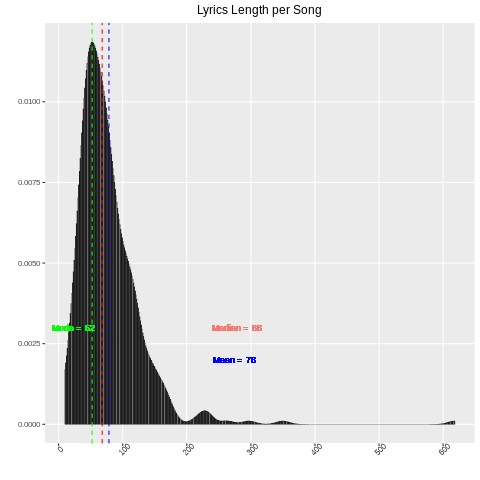

In [ ]:
%%R
lyrics_len_dist.plot

It is apparent from the figure that the average lyrics length per song is 78 words. The most typical lyrics length is about 52 words (the mode). 
Finally, the median is 68 words, which means that the number of songs with shorter length than the median is equal to those with length greater than the median.

In [ ]:
%%R
right_skwed_normal_est <- ggplot(lyrics_len_dist) + 
  stat_function(aes(x = num_words),
                col = "darkblue",
                fun = dsnorm,
                args = list(mean = param_dist$par["mean"],
                            sd = param_dist$par["sd"],
                            xi = param_dist$par["xi"])) +
  geom_vline(xintercept = param_dist$par["mean"], color = "blue", linetype = "dashed") + 
  geom_text(aes(x = 530, y = 0.002), color = "blue",
            label = paste("Mean = ", as.character(floor(param_dist$par["mean"])), 
                           ", sd = ", as.character(floor(param_dist$par["sd"])), 
                            ", xi = ", as.character(floor(param_dist$par["xi"]))                                                        
                          ),
            hjust = 1, size = 3) + 
  xlab("") + ylab("") + 
  ggtitle("Right-skewed normal distribution to estimate the density of lyrics lengths")

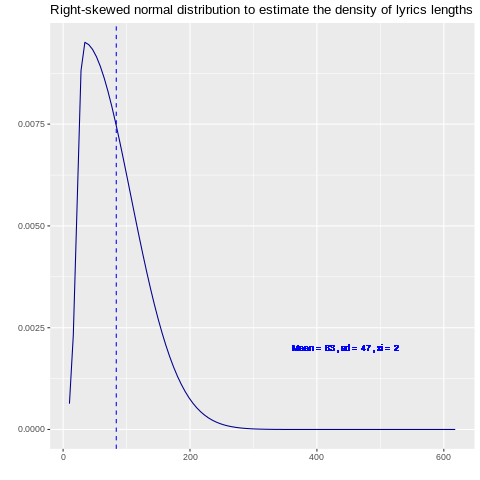

In [ ]:
%%R
right_skwed_normal_est

In [ ]:
%%R
#orca(lyrics_len_dist.plot, file = "/content/drive/MyDrive/Shadia/figs/lyrics_len_dist.pdf")
#orca(right_skwed_normal_est, file = "/content/drive/MyDrive/Shadia/figs/right_skwed_normal_est.pdf")
ggsave("/content/drive/MyDrive/Shadia/figs/lyrics_len_dist.pdf", lyrics_len_dist.plot, dpi = 1000, device = "pdf")
ggsave("/content/drive/MyDrive/Shadia/figs/right_skwed_normal_est.pdf", right_skwed_normal_est, dpi = 1000, device = "pdf")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


Free up memory

In [ ]:
%%R
rm("lyrics_len_dist")
rm("lyrics_len_dist.plot")
rm("right_skwed_normal_est")

## Studying word count per decade

This is done to see if the timeline of the career of Shadia has an effect on the length of her songs. For each decade we plot a histogram of the length of lyrics for songs created through that decade.

In [ ]:
%%R
full_word_count_decade <- songs.proc %>%
  dplyr::select(Song, Decade, Word) %>%
  group_by(Decade, Song) %>%
  mutate(num_words = n()) %>%
  dplyr::select(Song, Decade, num_words) %>%
  distinct() 

In [ ]:
%%R
full_word_count_decade <- full_word_count_decade %>%
  mutate(years = as.numeric(parse_number(Decade))) %>%
  mutate(part = ifelse(grepl("Early", Decade), 0, 1))

In [ ]:
%%R
full_word_count_decade <- full_word_count_decade %>%
  arrange(years, part) %>%
  mutate(Song_c = 1)

In [ ]:
%%R
full_word_count_decade <- within(full_word_count_decade, 
                                     Decade <- factor(Decade, levels = c("Late 1940s" , "Early 1950s", "Late 1950s", "Early 1960s", "Late 1960s", 
                                                                         "Early 1970s", "Late 1970s", "Early 1980s", "Late 1980s")))

full_word_count_decade.plot <- full_word_count_decade %>%
  ggplot() +
  geom_histogram(aes(x = num_words, fill = Song_c), 
                  boundary = 0, 
                  binwidth = 100, 
                  color = "black",
                  size = 0.15) + 
  facet_wrap(~Decade, scales = "free") +
  theme(plot.title = element_text(hjust = 0.5), 
        legend.title = element_blank(), 
        panel.grid.minor = element_blank(), 
        axis.text.x = element_text(angle = 40),
        text = element_text(size = 6.5),
        panel.spacing = unit(2, "lines")) +
  guides(fill = FALSE) + 
  ggtitle("Evolution of Song Length Across Decades") + 
  labs(x = NULL, y = "Song Count") +
  scale_x_continuous(breaks = seq(0, max(full_word_count_decade$num_words), 100), 
                     limits = c(0,max(full_word_count_decade$num_words))) +
  scale_y_continuous(breaks = function(x) unique(floor(pretty(seq(0, (max(x) + 1) * 1.1)))))
  #scale_y_continuous(breaks = seq(0, max.h.count))

  full_word_count_decade.plot <- ggplotly(full_word_count_decade.plot)

In [ ]:
%%R
full_word_count_decade.plot

As we notice from the previous figure the length of song lyrics increase as Shadia progresses in her career. At the beginning of her career that is in the early and late 1950s songs tend to be relatively short as almost all of them were sang in movies acted by her. All songs created in this period did not exceed 250 words. As she advanced in the 1970s more songs are created on theater paving the way for a little bit increase in the lyrics lengths. As we go into the 1980s, Shadia has done only two movies, so her songs were mostly either on theater or offline recorded in studio, hence, there is a shift towards long lyrics and long songs reaching more than $350$ words.

In [ ]:
%%R
orca(full_word_count_decade.plot, file = "/content/drive/MyDrive/Shadia/figs/full_word_count_decade.pdf")
# ggsave("/content/drive/MyDrive/Shadia/figs/full_word_count_decade.pdf", full_word_count_decade.plot, dpi = 1000, device = "pdf")

Free up memory

In [ ]:
%%R
rm("full_word_count_decade")
rm("full_word_count_decade.plot")

# Popular words

Here we do a simple evaluation of the most frequently used words in the full set of lyrics.

In [ ]:
%%R
top_words <- songs.proc %>%
  dplyr::select(Word) %>%
  group_by(Word) %>%
  summarize(word_freq = n()) %>%
  top_n(20) %>%
  ungroup() %>%
  arrange(word_freq)

Selecting by word_freq


In [ ]:
%%R
top_words.plot <- top_words %>%
  ggplot() +
  geom_col(aes(x = factor(Word, levels = unique(Word)), y = word_freq), width = 0.6) +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        panel.grid.minor = element_blank()) +
  labs(x = NULL, y = "Word Count") +
  scale_y_continuous(breaks = seq(0, max(top_words$word_freq), 100)) + 
  coord_flip()

top_words.plot <- ggplotly(top_words.plot)

In [ ]:
%%R
top_words.plot


As can be seen, the most frequent word is "قلبي" (my heart). This can be attributed to the fact that "heart" is essential in almost all genres of Egyptian culture. It caries romantic feelings, as well as nationalistic and religious emotions. Other top words that have romantic meanings include "حبيبى" (my love/my darling), "الحب" (the love), "بحبك" (I love you), "الهوى" (adoring). 

Some other words carry nationalistic feelings such as "بلدنا" (our home country); while others carry religious meanings such as "الله"(ALLAH/God).
Several words are neutral and their implied meanings have to be studied within the context (more n-grams) such as "الدنيا" (the world), "فين" (where), "بكره" (tomorrow). 
The others are mostly stop words that are missed from the used list of the package "arabicStemR". 
That is why we have used a list of top 20 words instead of the intended 10 words in order to account for that kind of noise.

In [ ]:
%%R
orca(top_words.plot, file = "/content/drive/MyDrive/Shadia/figs/top_words.pdf")
# ggsave("/content/drive/MyDrive/Shadia/figs/top_words.pdf", top_words.plot, dpi = 1000, device = "pdf")

In [ ]:
%%R
rm("top_words")
rm("top_words.plot")

# Word cloud

Word cloud is a *graphical* representation of words frequencies, where it gives greater prominence to words that appear more frequently.

In [ ]:
%%R
word_cloud <- songs.proc %>%
  dplyr::select(Word) %>%
  group_by(Word) %>%
  summarize(freq = n()) %>%
  arrange(desc(freq))

In [ ]:
%%R
word_cloud.plot <- word_cloud %>% 
  wordcloud2(size = 1, fontWeight = "normal", gridSize = 10)

In [ ]:
%%R
word_cloud.plot


More indicative words are apparent from the word cloud such as: "مصر" (Egypt), "الجماهير" (the masses), "بلدنا" (our home country), all of these carry nationalistic themes.

In [ ]:
%%R
rm("word_cloud")
rm("word_cloud.plot")

# Popular words per decade

So far we have studied the top words across all songs. What happens if we break them up by decade? Are some words more prevalent in songs that over certain decade(s)? These may be considered popular words by society with certain moods, political atmosphere, socioeconomic context, etc.

In [ ]:
%%R
no_of_tops <- 10

top_words_per_decade <- songs.proc %>%
  dplyr::select(Decade, Word) %>%
  group_by(Decade, Word) %>%
  mutate(freq = n()) %>%
  distinct() %>%
  ungroup() %>%
  group_by(Decade) %>%
  slice(seq_len(no_of_tops)) %>%
  arrange(desc(freq), .by_group = TRUE)
  #top_n(n = 10, wt = freq)

In [ ]:
%%R
top_words_per_decade <- top_words_per_decade %>%
  mutate(years = as.numeric(parse_number(Decade))) %>%
  mutate(part = ifelse(grepl("Early", Decade), 0, 1))

In [ ]:
%%R
top_words_per_decade <- top_words_per_decade %>%
  arrange(years, part) #%>%
  #mutate(.r = row_number())

In [ ]:
%%R
total_words_per_decade <- songs.proc %>%
  dplyr::select(Decade, Word) %>%
  group_by(Decade) %>%
  mutate(freq = n()) %>%
  dplyr::select(Decade, freq) %>%
  distinct()

In [ ]:
%%R

top_words_per_decade <- within(top_words_per_decade, 
                                     Decade <- factor(Decade, levels = c("Late 1940s" , "Early 1950s", "Late 1950s", "Early 1960s", "Late 1960s", 
                                                                         "Early 1970s", "Late 1970s", "Early 1980s", "Late 1980s")))

top_words_per_decade.plot <- top_words_per_decade %>%
  ggplot()  +
  #geom_col(aes(x = factor(Word, levels = unique(Word)), y = freq), width = 0.6) + 
  #geom_col(aes(x = Word, y = freq), width = 0.6) + 
  geom_col(aes(x = reorder_within(Word, freq, Decade), y = freq), width = 0.6) + 
  #geom_col(aes(x = .r, y = freq), width = 0.6) + 
  facet_wrap(~Decade, scales = "free") +
  scale_x_reordered() + 
  #scale_x_continuous(breaks = top_words_per_decade$Word, labels = top_words_per_decade$Word)
  theme(plot.title = element_text(hjust = 0.5),
          legend.title = element_blank(),
        panel.grid.minor = element_blank(),
        #axis.text.x = element_text(angle = 45),
        text = element_text(size = 8),
        panel.spacing = unit(2, "lines")) +
  coord_flip() + 
  guides(fill = FALSE) + 
  ggtitle("Top Words per Decade") + 
  labs(x = NULL, y = "Word Count") 
  #+ scale_y_continuous(breaks = seq(0, max(top_words_per_decade$freq), 10))

top_words_per_decade.plot <- ggplotly(top_words_per_decade.plot)

In the following we give a table of the total number of words of all songs performed in each decade.

In [ ]:
%%R
tab <- data.table::transpose(total_words_per_decade)
colnames(tab) <- tab[1,]
#formattable(tab[2,], row.names = FALSE, align = rep("c", ncol(tab)))
print(tab[2,], row.names = FALSE)

 Late 1940s Early 1950s Late 1950s Early 1960s Late 1960s Early 1970s
        623        7395       4412        5096       2944        3224
 Late 1970s Early 1980s Late 1980s   NA
        988        1275        474 2792


In [ ]:
%%R
top_words_per_decade.plot

Looking at the above table and figure, some interesting observations can be obtained as follows: 
- From the table it is evident that the bulk of Shadia's performance was in the middle of her career, which is naturally expected. 
Late 1980's witnessed her retirement so she performed the least. 
In the late 1940s, the beginning of her career, also witnessed the second smallest performing activities. 
The in-between decades witnessed a tremendous increase of singing. Of course, in all that analysis we take the total number of words as indicative of the performing activities. 
As thorough analysis can be performed based on rate of songs, rate of cooperation with different composers and lyricists. 
- The frequency of popular words differ significantly over the decades. At the core year of Shadia's career, the frequency of popular words are very high, whereas at the first and last decades (late 1940's and late 1980's) the frequencies of popular words drop significantly. This observation applies even taking into account the relativeness of the frequency of popular words with respect to the cumulative total number of words per decade. 
- As expected the romantic theme is predominant over the whole set of decades. However, there are some interesting differences in the words that express this theme. Words get more complicated over the decades both syntactically and semantically. Lyrics carry simple emotions prevail in the Late 1940s such as "متهيالك" (Apparent to You), "قول" (say), "حيرانه" (I am confused). Emotion get deeper and more intense in the early 1950's with words such as "قلبى" (my heart), "كيانى"(my being). In the late 1960s, words get more abstract and philosophical, probably carrying pessimistic attitudes, these include "الشوق" (the desire), "مخاصمنى" (quarreled with me). Such attitudes can in part be attributed to the political and social atmosphere in Egypt and the whole of the Arab region that resulted from the 1967 war. The 1970s in general witnessed a revert to simple words, though a bit less romantic and sensitive than the early period. Words in this period include "شراع" (sail), "ياريت" (I wish), "هتعرف" (you will know). 
- What is striking also is that there is no single word that is timeless, that is, top popular across all the decades. This might indicate the diversity and continuous evolution of Shadia. It might as well indicate the diversity of composers and lyricists that Shadia used to work with across different stages of her career. This can be investigated more thoroughly from the dataset we are working on.

In [ ]:
%%R
orca(top_words_per_decade.plot, file = "/content/drive/MyDrive/Shadia/figs/top_words_per_decade.pdf")
# ggsave("/content/drive/MyDrive/Shadia/figs/top_words_per_decade.pdf", top_words_per_decade.plot, dpi = 1000, device = "pdf")

In [ ]:
%%R
rm("top_words_per_decade")
rm("top_words_per_decade.plot")

# Word length

Word length is an interesting topic for lyricists. The longer the word, the harder it is to rhyme and squeeze into a pattern. Below we show a histogram of word lengths.

In [ ]:
%%R
word_length <- songs.proc %>%
  dplyr::select(Song, Decade, Word) %>%
  distinct() %>%
  mutate(word_len = nchar(Word)) %>%
  count(word_len, sort = TRUE)

In [ ]:
%%R
word_length$prob <- word_length$n / sum(word_length$n)
est_mean <- sum(word_length$prob * word_length$word_len)
t1 <- sum(word_length$prob * (word_length$word_len)^2)
t2 <- est_mean^2
est_var <- t1 - t2
est_sd <- sqrt(est_var)

word_length.plot <- word_length %>%
  ggplot(aes(x = word_len)) +
  geom_bar(aes(y = n/sum(word_length$n)),
           fill = "darkblue", 
           stat = "identity",
           size = 0.1) + 
  #geom_density() + 
  stat_function(col = "red", 
                fun = dnorm, 
                args = list(mean = est_mean, sd = est_sd)) +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        panel.grid.minor = element_blank(),
        text = element_text(size = 10)) +
  scale_x_continuous(breaks = seq(0, max(word_length$word_len), 1)) +
  #scale_y_continuous(breaks = seq(0, max(word_length$n), 500)) +
  ylab("Count") +
  xlab("Word Length") +
  ggtitle("Distribution of Word Length over the Whole Set of Songs") +
  geom_vline(xintercept = est_mean, color = "red", linetype = "dashed") + 
  geom_text(aes(x = 8, y = 0.25), color = "red",
             label = paste("Mean = ", as.character(est_mean)),
             hjust = 1, size = 3) +
  geom_text(aes(x = 8, y = 0.23), color = "red",
             label = paste("SD = ", as.character(est_sd)),
             hjust = 1, size = 3) #+ 

#word_length.plot <- ggplotly(word_length.plot)

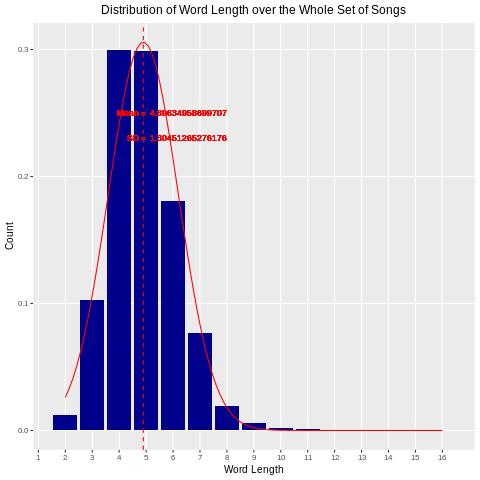

In [ ]:
%%R
word_length.plot

As indicated in the figure most of the words are short (between 4 to 6 characters) which indicates that Shadia was a kind of modernist in terms of short-worded lyrics and hence a kind of fast music, that can be considered new and revolutionary at the time. We look into the rather long words through the use of word cloud as follows.

In [ ]:
%%R
#orca(word_length.plot, file = "/content/drive/MyDrive/Shadia/figs/word_length.pdf")
ggsave("/content/drive/MyDrive/Shadia/figs/word_length.png", word_length.plot)

Saving 6.67 x 6.67 in image


In [ ]:
%%R
rm("word_length")
rm("word_length.plot")

In [ ]:
%%R
word_len_cloud <- songs.proc %>%
  dplyr::select(Word) %>%
  distinct() %>%
  mutate(word_len = nchar(Word)) %>%
  arrange(desc(word_len))

In [ ]:
%%R
cat("Total number of distinct words in all songs: ")
cat(nrow(word_len_cloud), "\n")

Total number of distinct words in all songs: 9497 


We show the word cloud only for only a subset of the whole set of words (the largest words).

In [ ]:
%%R
no_of_words <- 300

word_len_cloud.plot <- word_len_cloud[1:no_of_words, ] %>%
  wordcloud2(gridSize = 10,
             size = 0.15,
             minSize = .0005,
             ellipticity = .3,
             rotateRatio = 1,
             fontWeight = "bold")

In [ ]:
%%R
word_len_cloud.plot


From the word cloud it can be noticed that the big words are largely carrying nationalistic and political meanings. For example, "والاشتراكيه" (and the socialism), "والانتهازيه" (and the opportunism). Some are places like home country such as "بالجمهوريه" (in the Republic), "عالبورسعيديه" (on the port Saidia), etc. 
Still some words carry romantic and emotional tones such as "احلامنا الورديه" (our pink dreams), "الصبا والجمال" (boyhood and beauty), etc.

In [ ]:
%%R
no_of_words <- 300

word_len_cloud.plot_2 <- tail(word_len_cloud, 300) %>%
  wordcloud2(gridSize = 10,
             size = 0.15,
             minSize = .0005,
             ellipticity = .3,
             rotateRatio = 1,
             fontWeight = "bold")

In [ ]:
%%R
word_len_cloud.plot_2

In [ ]:
%%R
no_of_words <- 300

indices <- which((word_len_cloud$word_len == 4) | (word_len_cloud$word_len == 5))
random_indices <- indices[sample.int(length(indices), size = no_of_words, replace = FALSE)]
typical_words <- word_len_cloud[random_indices,]

In [ ]:
%%R
word_len_cloud.plot_3 <- typical_words %>%
  wordcloud2(gridSize = 10,
             size = 0.15,
             minSize = .0005,
             ellipticity = .3,
             rotateRatio = 1,
             fontWeight = "bold")

In [ ]:
%%R
word_len_cloud.plot_3

In [ ]:
%%R
rm("word_len_cloud")
rm("word_len_cloud.plot")
rm("word_len_cloud.plot_2")
rm("word_len_cloud.plot_3")

Next we do a finer study of the distribution of word length per decade.

In [ ]:
%%R
word_length_per_decade <- songs.proc %>%
   dplyr::select(Decade, Word) %>%
   distinct() %>%
   group_by(Decade) %>%
   mutate(word_len = nchar(Word)) #%>%
#  count(word_len, sort = TRUE)

In [ ]:
%%R
h <- hist(word_length_per_decade$word_len, breaks = seq(0, max(word_length_per_decade$word_len), 1), plot = F)
max.h.count <- max(h$counts)

word_length_per_decade <- within(word_length_per_decade, 
                                     Decade <- factor(Decade, levels = c("Late 1940s" , "Early 1950s", "Late 1950s", "Early 1960s", "Late 1960s", 
                                                                         "Early 1970s", "Late 1970s", "Early 1980s", "Late 1980s")))
word_length_per_decade.plot <- word_length_per_decade %>%
   ggplot() + 
   geom_histogram(aes(x = word_len, fill = ..count..), binwidth = 0.5) + 
   facet_wrap(~Decade, scales = "free") + 
   theme(plot.title = element_text(hjust = 0.5), 
         legend.title = element_blank(),
         panel.grid.minor = element_blank(), 
         text = element_text(size = 9)) +
  # scale_x_continuous(breaks = seq(0, max(word_length_per_decade$word_len), 1), 
  #                    limits = c(0, max(word_length_per_decade$word_len))) +
  # scale_y_continuous(breaks = seq(0, max.h.count, 100)) +
   xlab("Word Length")
  # ylab("Frequency") +
  #  +
  # ggtitle("Distribution of Word Length over the Whole Set of Songs")

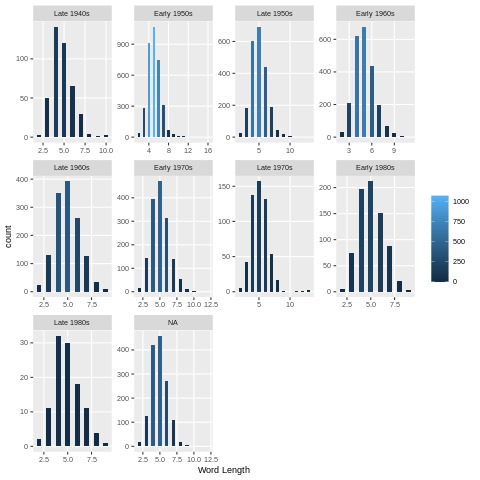

In [ ]:
%%R
word_length_per_decade.plot

As can be seen in the figure, the distribution of word length is almost the same across the 6 decades. Most words range from 4-5 characters in length.

In [ ]:
%%R
# orca(word_length_per_decade.plot, file = "/content/drive/MyDrive/Shadia/figs/word_length_per_decade.pdf")
ggsave("/content/drive/MyDrive/Shadia/figs/word_length_per_deacade.pdf", word_length_per_decade.plot, dpi = 1000, device = "pdf")

Saving 6.67 x 6.67 in image


In [ ]:
%%R
rm("word_length_per_decade")
rm("word_length_per_decade.plot")

# Lexical diversity

The more varied a vocabulary a text possesses, the higher its **lexical diversity**. Song vocabulary can be seen as a representation of how many unique words are used in a song. This can be shown with a simple graph of the average unique words per song over the decades/years.

In [ ]:
%%R
lex_diversity_per_year <- songs.proc %>%
  dplyr::filter(!is.na(Decade)) %>%
  dplyr::filter(!is.na(Year)) %>%
  group_by(Song, Year) %>%
  summarise(lex_diversity = n_distinct(Word)) %>%
  arrange(desc(lex_diversity))

`summarise()` has grouped output by 'Song'. You can override using the
`.groups` argument.


In [ ]:
%%R
lex_diversity_per_year.plot <- lex_diversity_per_year %>%
  ggplot(aes(x = Year, y = lex_diversity)) +
  geom_point(alpha = 0.4, 
             color = "darkblue",
             size = 2, 
             position = "jitter") +
  stat_smooth(color = "black", se = TRUE, method = "lm") + 
  geom_smooth(aes(x = Year, y = lex_diversity), 
              se = TRUE,
              color = "red", 
              lwd = 1) +
  theme(plot.title = element_text(hjust = 0.5), 
         legend.title = element_blank(),
         panel.grid.minor = element_blank(), 
         axis.text.x = element_text(angle = 45),
         text = element_text(size = 10)) +
  ggtitle("Lexical Diversity") +
  xlab("") + 
  ylab("") +
  scale_x_continuous(breaks = seq(min(lex_diversity_per_year$Year), max(lex_diversity_per_year$Year), 1)) +
  scale_y_continuous(breaks = seq(min(lex_diversity_per_year$lex_diversity), max(lex_diversity_per_year$lex_diversity), 20)) 
  #scale_color_manual(values = my_colors) +
  #theme_lyrics()

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


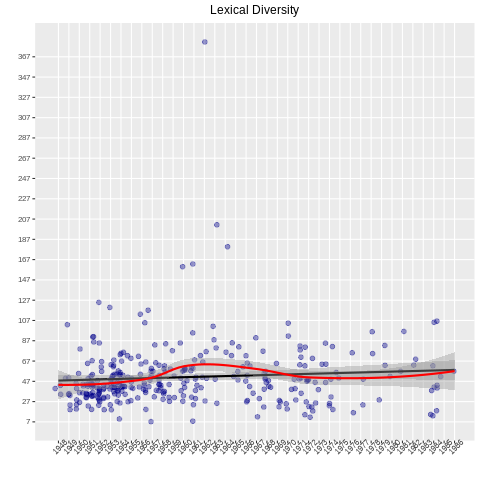

In [ ]:
%%R
lex_diversity_per_year.plot

In [ ]:
%%R
#orca(lex_diversity_per_year.plot, file = "/content/drive/MyDrive/Shadia/figs/lex_diversity_per_year.pdf")
ggsave(file = "/content/drive/MyDrive/Shadia/figs/lex_diversity_per_year.png", lex_diversity_per_year.plot)

Saving 6.67 x 6.67 in image
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


So, over the years there exists slight upward trend in the lyrics of Shadia. It is apparent that during the early 1960s (which can be considered the middle of Shadia's career), there is a greater diversity in lyrics. This hype of artistic activity can also be seen from the figure above showing the histogram of word length per decade, particularly, during the 1960s. In all of the above we have studied the lyrics words and lexical diversity using absolute measures. A more illuminating picture can be obtained using relativistic measures using lexical density.

In [ ]:
%%R
lex_diversity_per_year_2 <- lex_diversity_per_year %>%
  group_by(Year) %>%
  summarise(av_lex_diversity = mean(lex_diversity)) %>%
  arrange(desc(av_lex_diversity))

In [ ]:
%%R
lex_diversity_per_year.plot_2 <- lex_diversity_per_year_2 %>%
  ggplot(aes(x = Year, y = av_lex_diversity)) +
  geom_point(alpha = 0.4, 
             color = "darkblue",
             size = 2, 
             position = "jitter") +
  stat_smooth(color = "black", se = TRUE, method = "lm") + 
  geom_smooth(aes(x = Year, y = av_lex_diversity), 
              se = TRUE,
              color = "red", 
              lwd = 1) +
  theme(plot.title = element_text(hjust = 0.5), 
         legend.title = element_blank(),
         panel.grid.minor = element_blank(), 
         axis.text.x = element_text(angle = 45),
         text = element_text(size = 10)) +
  ggtitle("Average Lexical Diversity") +
  xlab("") + 
  ylab("") +
  scale_x_continuous(breaks = seq(min(lex_diversity_per_year_2$Year), max(lex_diversity_per_year_2$Year), 1)) +
  scale_y_continuous(breaks = scales::pretty_breaks(n = 20))
  #scale_y_continuous(breaks = seq(min(lex_diversity_per_year_2$av_lex_diversity),
   #                               max(lex_diversity_per_year_2$av_lex_diversity), 20)) 

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


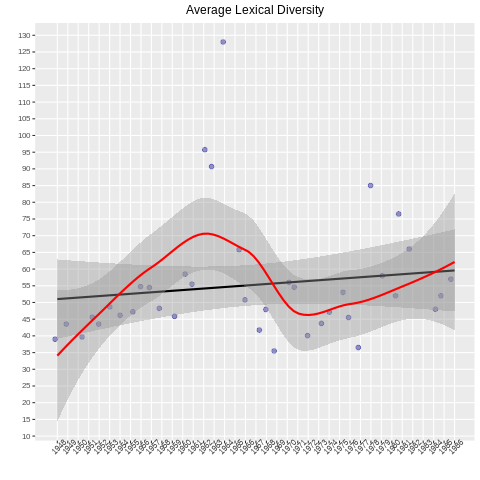

In [ ]:
%%R
lex_diversity_per_year.plot_2

In [ ]:
%%R
ggsave("/content/drive/MyDrive/Shadia/figs/av_lex_diversity_per_year.png", lex_diversity_per_year.plot_2)

Saving 6.67 x 6.67 in image
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


In [ ]:
%%R
rm("lex_diversity_per_year")
rm("lex_diversity_per_year.plot")
rm("lex_diversity_per_year_2")
rm("lex_diversity_per_year.plot_2")

# Lexical density

**Lexical density** is defined as the number of unique words in a song divided by the total number of words in that song. 
This is an indicator of *word repetition*, which is an important tool for the lyricist songwriter's tool. 
As lexical density increases, repetition decreases.
Note that this does not imply sequential repetition, which is yet another songwriting trick. In the following we will investigate the lexical diversity of Shadia's songs.

In [ ]:
%%R
lex_density_per_year <- songs.proc %>%
  dplyr::filter(!is.na(Decade)) %>%
  dplyr::filter(!is.na(Year)) %>%
  dplyr::select(Song, Year, Word) %>%
  group_by(Song, Year) %>%
  summarise(lex_density = n_distinct(Word)/n()) %>%
  arrange(desc(lex_density))

`summarise()` has grouped output by 'Song'. You can override using the
`.groups` argument.


In [ ]:
%%R
density_plot <- lex_density_per_year %>%
  ggplot(aes(Year, lex_density)) +
  geom_point(color = "darkblue", 
             alpha = .4, 
             size = 2, 
             position = "jitter") +
  stat_smooth(color = "black", 
                se = FALSE, 
                method = "lm") +
  geom_smooth(aes(x = Year, y = lex_density), 
                se = TRUE,
                color = "red", 
                lwd = 1) +
  theme(plot.title = element_text(hjust = 0.5), 
         legend.title = element_blank(),
         panel.grid.minor = element_blank(), 
         axis.text.x = element_text(angle = 45),
         text = element_text(size = 10)) + 
  ggtitle("Lexical Density") + 
  xlab("") + 
  ylab("") +
  scale_x_continuous(breaks = seq(min(lex_density_per_year$Year), max(lex_density_per_year$Year), 1)) +
  scale_y_continuous(breaks = seq(0, max(lex_density_per_year$lex_density), 0.1)) 

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


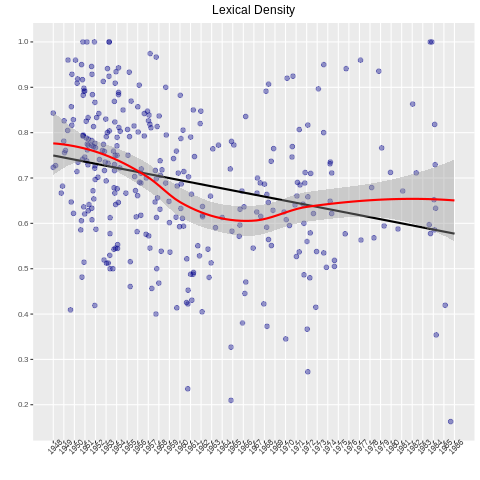

In [ ]:
%%R
density_plot

It is apparent from the figure that the trend is that the lexical density is decreasing with time, maybe following the general national and international trending of having short songs or songs with many word repetitions, the latter is more probable by looking at the lexical diversity plot in the figure above where there is an increasing trend in lexical diversity. There are extreme cases regarding the lexical density as seen by very dense songs and very sparse songs. Examples of the former include: "آه ياليله محلاكى" in 1975, and "انا اهواك" in 1953.
Examples of very sparse songs include: "يامولعين بالسهر" in 1969, and "رساله من تحت الماء" in 1975.

In [ ]:
%%R
lex_density_per_year_2 <- lex_density_per_year %>%
  group_by(Year) %>%
  summarise(av_lex_density = mean(lex_density)) %>%
  arrange(desc(av_lex_density))

In [ ]:
%%R
density_plot_2 <- lex_density_per_year_2 %>%
  ggplot(aes(Year, av_lex_density)) +
  geom_point(color = "darkblue", 
             alpha = .4, 
             size = 2, 
             position = "jitter") +
  stat_smooth(color = "black", 
                se = FALSE, 
                method = "lm") +
  geom_smooth(aes(x = Year, y = av_lex_density), 
                se = TRUE,
                color = "red", 
                lwd = 1) +
  theme(plot.title = element_text(hjust = 0.5), 
         legend.title = element_blank(),
         panel.grid.minor = element_blank(), 
         axis.text.x = element_text(angle = 45),
         text = element_text(size = 10)) + 
  ggtitle("Average Lexical Density") + 
  xlab("") + 
  ylab("") +
  scale_x_continuous(breaks = seq(min(lex_density_per_year$Year), max(lex_density_per_year$Year), 1)) +
  scale_y_continuous(breaks = seq(0, max(lex_density_per_year$lex_density), 0.1)) 

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


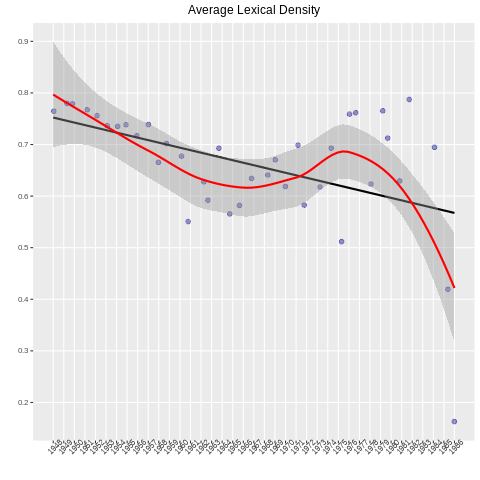

In [ ]:
%%R
density_plot_2

In [ ]:
%%R
rm("lex_density_per_year")
rm("density_plot")
rm("lex_density_per_year_2")
rm("density_plot_2")

Next we study the evolution of both lexical diversity and lexical density per decade to have a closer finer look and how they co-evolve together.

In [ ]:
%%R
lex_diversity_over_decade <- songs.proc %>%
  dplyr::filter(!is.na(Decade)) %>%
  dplyr::filter(!is.na(Year)) %>%
  dplyr::select(Decade, Song, Word) %>%
  group_by(Decade, Song) %>%
  summarise(lex_diversity = n_distinct(Word)) %>%
  ungroup() %>%
  dplyr::select(Decade, lex_diversity) %>%
  group_by(Decade) %>%
  summarise("Mean lex diversity" = mean(lex_diversity))

`summarise()` has grouped output by 'Decade'. You can override using the
`.groups` argument.


In [ ]:
%%R
lex_density_over_decade <- songs.proc %>%
  dplyr::filter(!is.na(Decade)) %>%
  dplyr::filter(!is.na(Year)) %>%
  dplyr::select(Decade, Song, Word) %>%
  group_by(Decade, Song) %>%
  mutate(lex_diversity = n_distinct(Word)) %>%
  mutate(no_words = n()) %>%
  ungroup() %>%
  dplyr::select(-c(Song, Word)) %>%
  distinct() %>%
  mutate(lex_density = lex_diversity/no_words) %>%
  group_by(Decade) %>%
  summarise("Mean lex density" = mean(lex_density))

In [ ]:
%%R
lex_diversity_density_over_decade <- inner_join(lex_diversity_over_decade,
                                                lex_density_over_decade,
                                                by = "Decade")

# lexical density values lie in the range [0,1], however, for proper plotting and comparison with lexical diversity in bar plots,
# we multiply the values of lexical density by 100.
lex_diversity_density_over_decade$"Mean lex density" <- 100 * lex_diversity_density_over_decade$"Mean lex density"

The following cell is just a trick for proper plotting of the two measures (lexical diversity and lexical density) in one bar plot.

In [ ]:
%%R
lex_diversity_density_over_decade <- lex_diversity_density_over_decade %>%
  gather("lex_div_den", "value", -Decade)

In [ ]:
%%R
lex_diversity_density_over_decade <- lex_diversity_density_over_decade %>%
  mutate(years = as.numeric(parse_number(Decade))) %>%
  mutate(part = ifelse(grepl("Early", Decade), 0, 1))

In [ ]:
%%R
lex_diversity_density_over_decade <- lex_diversity_density_over_decade %>%
  arrange(years, part) %>%
  dplyr::select(-c(years, part))

In [ ]:
%%R
#X <- lex_diversity_density_over_decade$value[which(lex_diversity_density_over_decade$lex_div_den == "Mean lex density")]
#exp_d <- fitdist(X, "exp")

In [ ]:
%%R
lex_diversity_density_over_decade.plot <- lex_diversity_density_over_decade %>%
  ggplot() + 
  geom_bar(aes(x = factor(Decade, levels = unique(Decade)), y = value, fill = lex_div_den),
           stat = "identity",
           position = "dodge") +
  theme(plot.title = element_text(hjust = 0.5), 
         legend.title = element_blank(),
         panel.grid.minor = element_blank(), 
         axis.text.x = element_text(angle = 40),
         text = element_text(size = 10)) +
  xlab("") + 
  ylab("") +
  ggtitle("Lexical Diversity/Density over the Decades") + 
  scale_y_continuous(breaks = scales::pretty_breaks(n = 10))

lex_diversity_density_over_decade.plot <- ggplotly(lex_diversity_density_over_decade.plot)

In [ ]:
%%R
lex_diversity_density_over_decade.plot

It is apparent from the figure that the lexical density tends to be stable over the years, though it decreases slowly with time. 
So from probabilistic perspective it seems that the lexical density follows an exponential distribution with rather low rate. 
On the other hand lexical diversity can be thought as following a Gaussian distribution with the mean in the late 1960s. 
This peak happens even though the lexical density is rather low. The latter can then be attributed to having many repetitions in the songs in this period of time. This diversity of lyrics can as well be seen from the table above showing the total number of words in all songs in late 1960s to be $14,892$ which is the largest across all decades. This indicates that Shadia had been most active in the late 1960s. One of the reasons can be attributed to the defeat in war in 1967 and the need to reinstate the nationalist feelings of the people in addition for the need to give many concerts for fund raising and donations for the war effort to rebuild the army.

In [ ]:
%%R
orca(lex_diversity_density_over_decade.plot, file = "./figs/div_density_over_decade.pdf")
#ggsave("/content/drive/MyDrive/Shadia/figs/div_density_over_deacade.pdf", lex_diversity_density_over_decade.plot, dpi = 1000, device = "pdf")

In [ ]:
%%R
rm("lex_diversity_over_decade")
rm("lex_density_over_decade")
rm("lex_diversity_density_over_decade")
rm("lex_diversity_density_over_decade.plot")

# TF-IDF

The method that we have been using so far looks at the entire dataset, but it has not addressed how to quantify just how important various terms are in a document with respect to an entire collection. In the analysis above we have removed stop words and looked at term frequency, but this is not be the most sophisticated approach, especially from a relativistic perspective. An advanced alternative is the use of TF-IDF, where TF stands for "Term Frequency" and IDF stands for "Inverse Term Frequency". TF-IDF assigns a lower weight to commonly used words and higher weights to words that are not used much in the given collection.

When TF and IDF are combined, a term's significance is adjusted for how rarely it is used. The assumption behind TF-IDF is that **terms that appear more frequently in a document should be given a higher weight, unless it also appears in many documents**. It can be formulated as follows: 
- Term Frequency (TF): Number of times a term occurs in a document (fixing the document). 
- Document Frequency (DF): Number of documents that contain each word (fixing the word). 
- Inverse Document Frequency (IDF) = 1/DF - TF-IDF = TF \* IDF

The IDF of any term is therefore a higher number for words that occur in fewer of the documents in the collection, so it is a kind of rare words from which their importance are driven. 
We will next see this approach to examine the most important words per year/decade/and overall.

In [ ]:
%%R
popular_tfidf_words <- songs.proc %>%
  dplyr::select(Song, Word) %>%
  dplyr::filter(nchar(Word) > 3) %>%
  group_by(Song) %>%
  count(Song, Word, sort = TRUE) %>%
  ungroup() %>%
  bind_tf_idf(Word, Song, n) %>%
  arrange(desc(tf_idf))

In [ ]:
%%R
popular_tfidf_words <- popular_tfidf_words %>% 
  dplyr::select(-n)

The following table gives the topmost words with respect to their TF-IDF values.

In [ ]:
%%R
topmost <- 10

test_sample <- popular_tfidf_words[1:topmost,]  %>%
  ungroup() %>%
  mutate(Word = color_bar("lightblue")(Word))  %>%
  mutate(Song = color_tile("lightpink","lightpink")(Song)) %>%
  #mutate(n = color_tile("lightgreen","lightgreen")(n)) %>%
  mutate(tf = color_tile("lightpink","lightpink")(tf)) %>%
  mutate(idf = color_tile("lightblue","lightblue")(idf)) %>%
  mutate(tf_idf = color_tile("lightgreen","lightgreen")(tf_idf)) %>%
  kable("html", escape = FALSE, align = "c", caption = "Words with highest TF-IDF") %>%
  kable_styling(bootstrap_options = c("striped", "condensed", "bordered"),
                    full_width = FALSE)

In [ ]:
%%R
test_sample

As can be noticed from this table it is clear that the words are not that typical of songs, especially from a singer mostly known for romantic themes. 
So these words are rare across songs, however, they are very typical in few songs. The topmost words include: "اضرب", (hit), "انذار", (warning), "تلمني" (blame me), "وغني" (and sing), "الويل" (woe). 
The following shows the converse, namely the words with least TF-IDF values, which are words that are either very atypical in any particular song or very typical accross many songs.

The following table gives the lowermost words with respect to their TF-IDF values.

In [ ]:
%%R
lowermost <- 10

test_sample <- tail(popular_tfidf_words, n = lowermost)  %>%
  map_df(rev) %>%
  ungroup() %>%
  mutate(Word = color_bar("lightblue")(Word)) %>%
  mutate(Song = color_tile("lightpink","lightpink")(Song)) %>%
  #mutate(n = color_tile("lightgreen","lightgreen")(n)) %>%
  mutate(tf = color_tile("lightpink","lightpink")(tf)) %>%
  mutate(idf = color_tile("lightblue","lightblue")(idf)) %>%
  mutate(tf_idf = color_tile("lightgreen","lightgreen")(tf_idf)) %>%
  kable("html", escape = FALSE, align = "c", caption = "Words with lowest TF-IDF") %>%
  kable_styling(bootstrap_options = c("striped", "condensed", "bordered"),
                     full_width = FALSE)

In [ ]:
%%R
test_sample

As expected the terms with the lowest TF-IDF are the very common words that can appear frequently inside a given songs and appear across many songs. 
There include "اللى", (the one), "الدنيا", (the life), "قلبي" (my heart), "وانا" (and I).

In [ ]:
%%R
popular_tfidf_words.plot <- popular_tfidf_words %>%
  ggplot() + 
  geom_histogram(aes(x = tf_idf),
                 stat = "density",
                 #boundary = 0,
                 #binwidth = 100,
                 color = "darkblue",
                 size = 0.15) + 
  theme(plot.title = element_text(hjust = 0.5),
         legend.title = element_blank(),
         panel.grid.minor = element_blank(),
         #axis.text.x = element_text(angle = 45),
         text = element_text(size = 10)) +
  ggtitle("Normalized Histogram for TF-IDF Values") + 
  xlab("") + 
  ylab("") +
  scale_x_continuous(breaks = scales::pretty_breaks(n = 10))
  # scale_x_continuous(breaks = seq(min(lex_density_per_year$Year), max(lex_density_per_year$Year), 1)) +
  # scale_y_continuous(breaks = seq(0, max(lex_density_per_year$lex_density), 0.1)) 

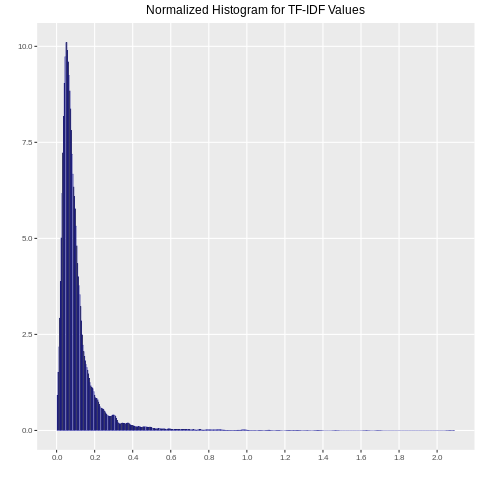

In [ ]:
%%R
popular_tfidf_words.plot

In [ ]:
%%R
#orca(popular_tfidf_words.plot, file = "/content/drive/MyDrive/Shadia/figs/popular_tfidf_words.pdf")
ggsave("/content/drive/MyDrive/Shadia/figs/popular_tfidf_words.pdf", popular_tfidf_words.plot, dpi = 1000, device = "pdf")

Saving 6.67 x 6.67 in image


The following is a word cloud of the most popular words (according to the TF-IDF measure) across the whole artistic career of Shadia.

In [ ]:
%%R
word_cloud_overall <- popular_tfidf_words %>%
  arrange(desc(tf_idf)) %>%
  dplyr::select(Word, tf_idf)

In [ ]:
%%R
wordcloud2(word_cloud_overall[1:300, ],
           color = "random-dark", 
           minRotation = -pi / 6, 
           maxRotation = -pi / 3, 
           minSize = .002, 
           ellipticity = .3, 
           rotateRatio = 1, 
           size = .2, 
           fontWeight = "bold", 
           gridSize = 1.5 )

As can be seen from the word cloud the most popular words, unlike common perspective of romanticism of Shadia, are words that carry nationalistic and enthusiastic themes.

In [ ]:
%%R
rm("popular_tfidf_words")
rm("test_sample")
rm("word_cloud_overall")
rm("popular_tfidf_words.plot")

Next we do that analysis more finer by dividing it into the decades. So here the TF-IDF values are computed with respect only to the given decade.

In [ ]:
%%R
popular_tfidf_words_per_decade <- songs.proc %>%
  dplyr::select(Decade, Song, Word) %>%
  dplyr::filter(nchar(Word) > 3) %>%
  group_by(Decade, Song) %>%
  count(Decade, Song, Word, sort = TRUE) %>%
  ungroup() %>%
  group_by(Decade) #%>%
  #bind_tf_idf(Word, Song, n) #%>%
  # arrange(desc(tf_idf))

In [ ]:
%%R
decades <- popular_tfidf_words_per_decade %>% group_split()
decades_after <- NULL
decades_wordclouds <- list()
for(i in 1:length(decades))
{
  dd <- decades[[i]] %>%
    group_by(Song) %>%
    bind_tf_idf(Word, Song, n)
  decades_after <- rbind(decades_after, dd)
  
  decades_wordclouds[[i]] <- dd[1:300,] %>%
    ungroup() %>%
    dplyr::select(Word, tf_idf) %>%
    arrange(desc(tf_idf))
  decades_wordclouds[[i]] <- wordcloud2(decades_wordclouds[[i]],
                                        color = "random-dark",
                                        minRotation = -pi / 6,
                                        maxRotation = -pi / 3,
                                        minSize = .002,
                                        ellipticity = .3,
                                        rotateRatio = 1,
                                        size = .2,
                                        fontWeight = "bold",
                                        gridSize = 1.5 )
}

In [ ]:
%%R
no_of_top_songs <- 10

popular_tfidf_words_per_decade <- decades_after %>%
  distinct() %>%
  group_by(Decade) %>%
  arrange(desc(tf_idf), .by_group = TRUE) %>%
  slice(seq_len(no_of_top_songs)) 

In [ ]:
%%R

popular_tfidf_words_per_decade <- within(popular_tfidf_words_per_decade, 
                                     Decade <- factor(Decade, levels = c("Late 1940s" , "Early 1950s", "Late 1950s", "Early 1960s", "Late 1960s", 
                                                                         "Early 1970s", "Late 1970s", "Early 1980s", "Late 1980s")))

top_tf_idf_words_per_decade.plot <- popular_tfidf_words_per_decade %>%
  ggplot()  +
  #geom_col(aes(x = Word, y = tf_idf), width = 0.6) +
  ##geom_col(aes(x = factor(Word, levels = unique(Word)), y = freq), width = 0.6) + 
  ##geom_col(aes(x = Word, y = freq), width = 0.6) + 
  geom_col(aes(x = reorder_within(Word, tf_idf, Decade), y = tf_idf), 
           width = 0.6) + 
  ##geom_col(aes(x = .r, y = freq), width = 0.6) + 
  facet_wrap(~Decade, scales = "free") +
  scale_x_reordered() + 
  ##scale_x_continuous(breaks = top_words_per_decade$Word, labels = top_words_per_decade$Word)
  theme(plot.title = element_text(hjust = 0.5),
         legend.title = element_blank(),
       panel.grid.minor = element_blank(),
       axis.text.x = element_text(angle = 40),
       text = element_text(size = 8),
       panel.spacing = unit(2, "lines")) +
  coord_flip() + 
  guides(fill = FALSE) + 
  ggtitle("Important Words Using TF-IDF per Decade") + 
  labs(x = "Word", y = "TF-IDF") #+
  #scale_y_continuous(breaks = seq(0, max(top_words_per_decade$freq), 10))

top_tf_idf_words_per_decade.plot <- ggplotly(top_tf_idf_words_per_decade.plot)

In [ ]:
%%R
top_tf_idf_words_per_decade.plot

Relativizing the computation of the TF-IDF to a decade gives a glimpse over the general themes and genres that distinguish every such decade.
As can be seen the popular words (with respect to the TF-IDF measure) are quite different across different decades and even quite different from the popular words (with respect to the TF-IDF measure) computed over the whole career life of Shadia. It is evident that the nationalist theme dominates the 1960s, especially the latter part. 

The nationalist focus in the late 1960s can be attributed to the ongoing war between Israel from one side and Egypt (with several other Arab nations) on the other side. 
The nationalist theme appear, however, on the surface, in other decades. 
The early 1950s themes seemed to come around romanticism and optimistic perspectives over life. 
The later 1950s is mostly about romanticism and a bit of nationalism. 
The nationalistic tone in the late 1950s and early 1960s are mild and carry optimism about the future perspectives of the revolution (that occurred in 1950s). 

However, the nationalistic themes in the late 1960s are strong and carry fighting and sacrifice tones which can be naturally understood given the political situation and the ongoing hot wars between Israel and Egypt at the time. The 1970s in general carry a sense of wisdom and pessimism that can be attributed to several factors: 

(1) the first is the huge political and soco-economic changes that had been occurring in Egypt that came on extreme contrast to the previous period and 
(2) the particular state of affairs concerning Shadia himself as he was becoming very sick and approaching the end of his life.

In [ ]:
%%R
orca(top_tf_idf_words_per_decade.plot, file = "/content/drive/MyDrive/Shadia/figs/top_tf_idf_words_per_decade.pdf")
# ggsave("/content/drive/MyDrive/Shadia/figs/top_tf_idf_words_per_decade.pdf", top_tf_idf_words_per_decade.plot, dpi = 1000, device = "pdf")

In [ ]:
%%R
par(mfrow = c(3,2))
decades_wordclouds[[1]]
decades_wordclouds[[2]]
decades_wordclouds[[3]]
decades_wordclouds[[4]]
decades_wordclouds[[5]]
decades_wordclouds[[6]]

In [ ]:
%%R
rm("popular_tfidf_words_per_decade")
rm("decades")
rm("decades_after")
rm("decades_wordclouds")

# Conclusion

In this case study, we have taken a quick glance into the actual data.
After performing some conditioning such as data cleansing and removing uninformative words, we began an exploratory analysis at the song level.
Next, we delved deeper into text mining by unnesting lyrics into tokenized words so that we could look at lyrical complexity.